# System Identification

In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from gekko import GEKKO

In [ ]:
df2=pd.read_excel('CC_74869-184828.xlsx',header=0,index_col=0)
df2.columns = [ 'F', 'FW', 'P', 'MS', 'BP1_only','SW','SL','D','PS','CP','BP','D50'] ### *** change depend on data set

In [ ]:
# df0=df2.copy()
# df6 = df0[#(df0['F'] >= 0 )& (df0['Feed'] < 1600) &
#           (df0['FW'] >= 0.01 )&
#           #(df0['SW'] >= 0.01 )&
#          (df0['MS'] > 1) &
#           #(df0['PS']>= 50)&
#           #(df0['CP']>= 0.01)& #all
#           (df0['P']> 1)&
#          #(df0['BP']> 0)&
#          (df0['D']> 15)&
#          (df0['D50']< 0.7 )] #all
# print('new data set len',len(df6),'diff',len(df6)-len(df0))

In [ ]:
train=df6.reset_index()
train.plot(subplots=True)
plt.show()

In [ ]:
#If desired to exclude certain correlations can do individually per CV, then concatenate. 

from gekko import GEKKO
t = train['index']
u = train[['F','FW','MS','SL','CP']]   #DIFFERENT, NEW NEW
y = train[['BP','P','D','D50']]

# generate time-series model
m = GEKKO()

##################################################################
# system identification
na = 2 # output coefficients
nb = 4 # input coefficients
print('Identify model')
yp,p,K = m.sysid(t,u,y,na,nb,objf=10000,scale=True,diaglevel=1,pred='meas')#,shift='none')

In [2]:
#p = {'a':A,'b':B,'c':C} #run to save
with open('p_gek_5_4_03.pkl', 'wb') as file:
    pickle.dump(p, file)

# MPC *TEST* with New set of MVs/ CVs

In [103]:
import pickle
with open('p_gek_5_4_05.pkl', 'rb') as file:   # na=2 nb=4
    p = pickle.load(file)
    
#new p array: ARX coefficients
MV=['F','FW','MS','SL','CP']
CV=['BP','P','D','D50']

In [94]:
# Get initial Process data just for 5 time steps.
df0=pd.read_excel('CC_185802-229370.xlsx',header=0,index_col=0)   #training set. last few weeks of data
df0.head()

df0.columns = ['F', 'FW', 'P', 'MS', 'BP_1', 'SW', 'SL', 'D', 'PS', 'CP', 'BP','D50']
#df0.columns = ['min','F', 'FW','MS','PS','SW','BP','P','SL', 'D', 'CP', 'D50']
#attention
df=df0.iloc[60:]  #after startup



In [ ]:
df.iloc[0:50].plot(subplots=True)
plt.show()

Acceptable Ranges
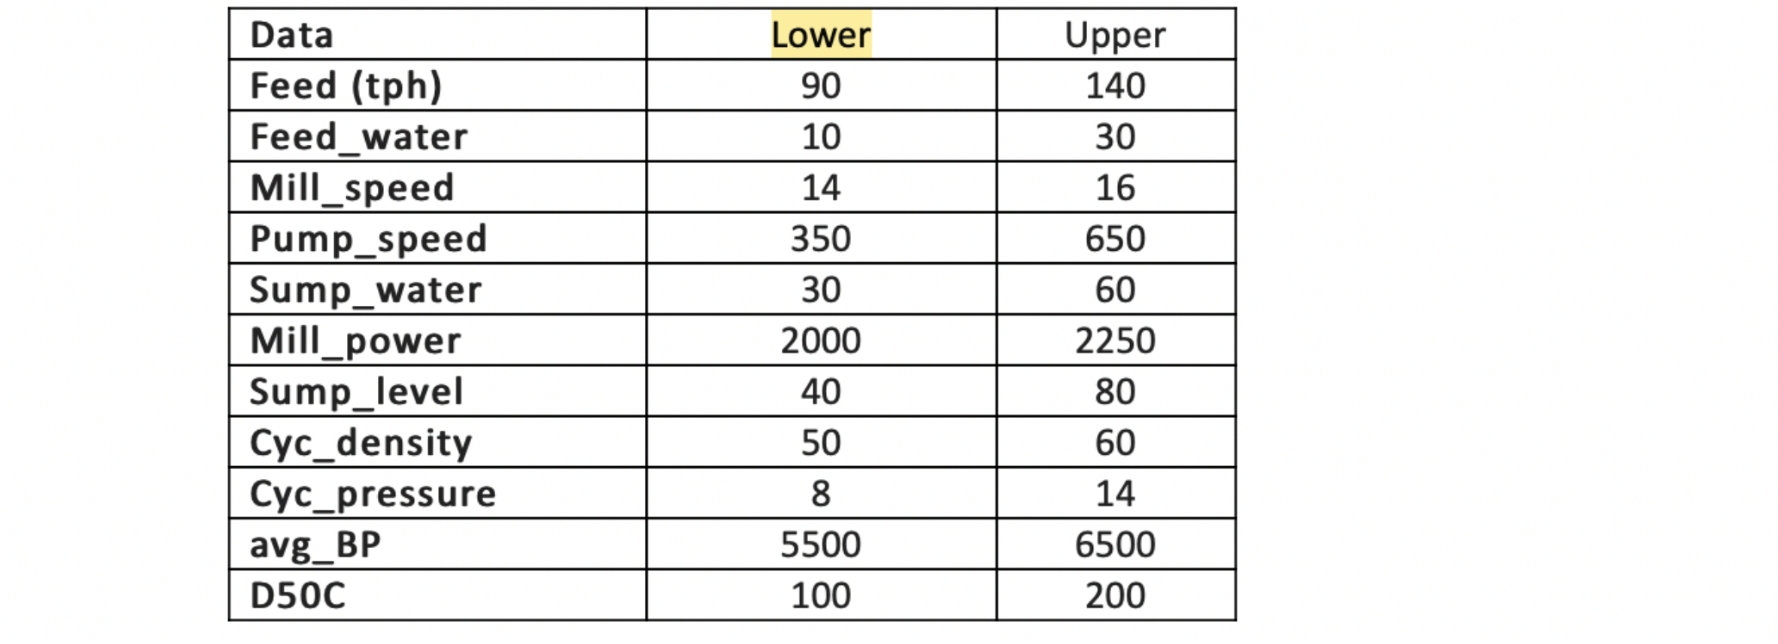

 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :            9
   Intermediates:            0
   Connections  :            9
   Equations    :            0
   Residuals    :            0
 
 Number of state variables:             46
 Number of total equations: -           46
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Steady State Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.16934E-33  1.86646E+02
    1  5.16934E-33  1.86646E+02
 Success

<Figure size 640x480 with 0 Axes>

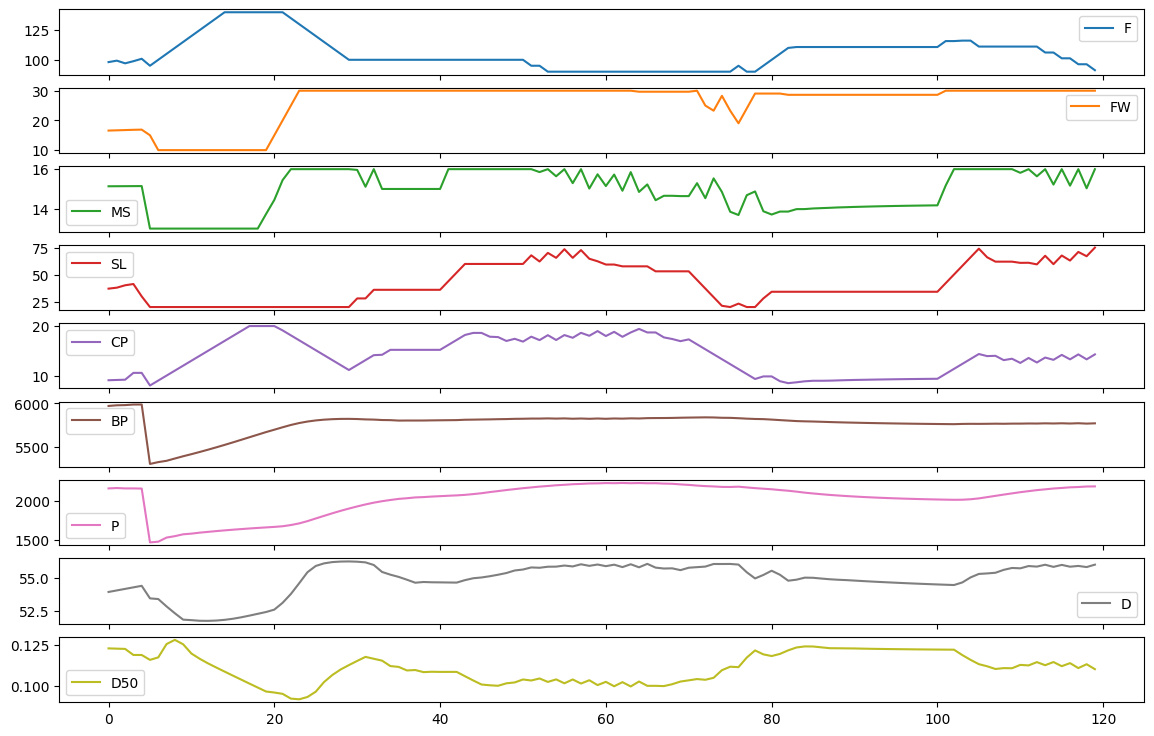

In [141]:
######  Full Controller                ######
######  MPC Grinding Circuit           ######
######  Th 15 Jun 2023                 ######
######  Erik Hobson                    ######
######  Based on ARX of na=2 and nb=4  ######
######  MV's: F, FW, MS, SL, CP        ######
######  CV's: BP, P, D, D50            ######

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import json
from gekko import GEKKO

######################
# Final time
tf =120  # min
n = tf * 1 + 1
######################

#write arrays for testing/plotting controller results.
dfw=np.zeros((5,n)) 
for i, tag in enumerate([dfw[0],dfw[1],dfw[2],dfw[3],dfw[4]]):  #Reading starting values
    tag[0]=df[MV[i]].iloc[0]
    tag[1]=df[MV[i]].iloc[1]
    tag[2]=df[MV[i]].iloc[2]
    tag[3]=df[MV[i]].iloc[3]
    tag[4]=df[MV[i]].iloc[4]

dfr=dfw.copy()

#write cv simulated outputs for testing controller
dfx=np.zeros((4,n)) 

# MVs read from "process":
Fs  = np.zeros(n)
FWs = np.zeros(n)
MSs = np.zeros(n)
SLs = np.zeros(n)
CPs = np.zeros(n)

for i, tag in enumerate([Fs,FWs,MSs,SLs,CPs]):  #Reading MV starting values. 
    tag[0]=df[MV[i]].iloc[0]                    #would read from process.  
    tag[1]=df[MV[i]].iloc[1]                    # (could instead read one point and replicate)
    tag[2]=df[MV[i]].iloc[2]
    tag[3]=df[MV[i]].iloc[3]
    tag[4]=df[MV[i]].iloc[4]

#Write to Process MVs:
F_w = Fs.copy()
FW_w=FWs.copy()
MS_w=MSs.copy()
SL_w=SLs.copy()
CP_w=CPs.copy()
    
# CV values measurement arrays
BPm  = df['BP'].iloc[0] * np.ones(n)
Pm   = df['P'].iloc[0]  * np.ones(n)
Dm   = df['D'].iloc[0]  * np.ones(n)
D50m = df['D50'].iloc[0]* np.ones(n)

for i, tag in enumerate([BPm,Pm,Dm,D50m]):  #Reading MV starting values. 
    tag[0]=df[CV[i]].iloc[0]                #would read from process.
    tag[1]=df[CV[i]].iloc[1]
    tag[2]=df[CV[i]].iloc[2]
    tag[3]=df[CV[i]].iloc[3]
    tag[4]=df[CV[i]].iloc[4]
    tag[5]=df[CV[i]].iloc[5]
    
# CV setpoints
BPsp = BPm*1.0
Psp  = Pm*1.0
Dsp  = Dm*1.0
D50sp= D50m*1.0

# set sp's for each CV.  Ideal conditions:
BPsp [5:] = 6250
Psp  [5:] = 2200
Dsp  [5:] = 55
D50sp[5:] = 0.110

#Changes. For Testing
def change(name,i,sp):
    try:
        BPsp [i:] = 6250        #   15 min settling time
        Psp  [i:] = 2200
        Dsp  [i:] = 55
        D50sp[i:] = 0.110
        name [i:] = sp
    except:
        print('increase tf')
        
change(D50sp,40,0.100)
change(D50sp,70,0.125)
change(D50sp,100,0.110)
# change(Dsp,45,48)
# change(Psp,80,1900)

#########################################################
# Initialize Models    
#########################################################

MV = [ 'F', 'FW', 'MS', 'SL', 'CP']
CV = ['BP','P', 'D', 'D50']

#create ARX model:
m = GEKKO(remote=False)
y = m.Array(m.CV,4)
u = m.Array(m.MV,5)

y,u = m.arx(p,y,u)

#initial value match to df values. will need to read value from process on real startup?
# for i in range(len(y)):
#     y[i].value=df[CV[i]].iloc[0]  

# rename CVs
BP = y[0]
P  = y[1]
D  = y[2]
D50= y[3]

# rename MVs
F  = u[0]
FW = u[1]
MS = u[2]
SL = u[3]
CP = u[4]

# # steady state initialization
m.options.IMODE = 1
m.solve()

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 1 # 3 IPOPT             # change to 1, APOPT if infeasibility
m.time=np.linspace(0,30,31) #set above.

########################################
#Parameters, limits, and specifications

#deadbands for SPs:
dbd={'BP': 500,'P': 200,'D':1.0,'D50':0.003}

#Dictionary of variable limits
lim_dict = {
# Controlled variables
'BP': [5500, 6500],
'P': [2000, 2250],
'D': [50, 60],
'D50': [0.1, 0.2],

# Manipulated variables
'F': [90, 140],
'FW': [10, 30],
'MS': [13, 16],
'SL': [20, 80],
'CP': [8, 20],      #these bands keep controller from exceeding bounds
}
dmax_dict={'F': 5,'FW': 5,'MS': 1,'SL': 8,'CP': 1}   #this is for 1 min intervals #cramped SL and CP

dcost_dict={'F': 0.0001,'FW': 0.0001,'MS': 0.001,'SL': 0.01,'CP': 0.01} #default 0.00001 #increase for less movement

###########################
for i,mv_i in enumerate(u):
    tag = MV[i]
    mv_i.STATUS = 1     #controlled
    mv_i.FSTATUS = 0    #process: change to 1 
    mv_i.LOWER = lim_dict[tag][0]
    mv_i.UPPER = lim_dict[tag][1]
    mv_i.DMAX = dmax_dict[tag]
    mv_i.DCOST = dcost_dict[tag]

###########################
for i,cv_i in enumerate(y):
    tag = CV[i]
    cv_i.STATUS = 1
    cv_i.FSTATUS = 1
    cv_i.TAU = 1 
    cv_i.TR_INIT = 0  #default 0 set 2
    cv_i.TR_OPEN = 1  #ratio of initial to final gap sphi/lo. can change to 0 for ref traj, 1 is default. 2 is ratio of open to final db

#################################################################################################################################################
# Control Loop IMODE= 6 #
#################################################################################################################################################

start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
#   while q==1:
    for i in range(4,n-1):
        print(f'Time {i}')
        # Sleep time
        sleep_max = 1.0  # THIS will be 1 minute in process, but is faster for testing
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Previously solved simulated CV value
        if i>=5:
            BPm[i] =smbp
            Pm[i]  =smp 
            Dm[i]  =smd 
            D50m[i]=smd50

        # Insert measurements
        BP.MEAS  = BPm[i]
        P.MEAS   =  Pm[i]
        D.MEAS   =  Dm[i]
        D50.MEAS =D50m[i]

        BP.SPHI = BPsp[i] + dbd['BP']
        BP.SPLO = BPsp[i] - dbd['BP']
        P.SPHI = Psp[i] + dbd['P']
        P.SPLO = Psp[i] - dbd['P']
        D.SPHI = Dsp[i] + dbd['D']
        D.SPLO = Dsp[i] - dbd['D']
        D50.SPHI = D50sp[i] + dbd['D50']
        D50.SPLO = D50sp[i] - dbd['D50']


        m.options.MAX_TIME= 57.0
        try:
            m.solve(disp=False)
            m.options.TIME_SHIFT=1
        except:
            m.options.TIME_SHIFT=2
            print('failed soln')
            
        #Setting MV targets starting at the next step in time
        F_w[i+1]   = F.NEWVAL
        FW_w[i+1]  =FW.NEWVAL
        MS_w[i+1]  =MS.NEWVAL        
        SL_w[i+1]  =SL.NEWVAL
        CP_w[i+1]  =CP.NEWVAL
        
        # "Measured MV values"  
        Fs[i+1]   =  F.value[1] *1.0
        FWs[i+1]  = FW.value[1] *1.0
        MSs[i+1]  = MS.value[1] *1.0       
        SLs[i+1]  = SL.value[1] *1.0 #+10*np.sin(i*8/7*np.pi)  #Sump Level disturbance (more real)
        CPs[i+1]  = CP.value[1] *1.0 #*0.6 +CP.value[0]*0.4     #To Slow Cyclone pressure response (more real)

###############################################################################################################################
#simulate CV response:
###############################################################################################################################
# SIMULATOR IMODE=4  # 
        sm = GEKKO(remote=False)

        sy = sm.Array(sm.CV,4)
        su = sm.Array(sm.MV,5)

        for k in range(len(sy)):           #set initial condition from process reading
            sy[k].value=df[CV[k]].iloc[0]

        sy,su = sm.arx(p,sy,su)    #p array is ARX coefficients
        tf = i                     # simulate to present time +1
        
        u1 = np.zeros(tf+1)
        u2 = u1.copy()
        u3 = u2.copy()
        u4 = u3.copy()
        u5 = u4.copy()

        u1[0:] = Fs[0:tf+1]     #sensor history of MV to present
        u2[0:] = FWs[0:tf+1]
        u3[0:] = MSs[0:tf+1]
        u4[0:] = SLs[0:tf+1]
        u5[0:] = CPs[0:tf+1]

        su[0].value = u1
        su[1].value = u2
        su[2].value = u3
        su[3].value = u4
        su[4].value = u5

        mv1 = su[0]; mv2 = su[1]; mv3 = su[2]; mv4 = su[3]; mv5 = su[4]
        cv1 = sy[0]; cv2 = sy[1]; cv3 = sy[2]; cv4 = sy[3];

        sm.time = np.linspace(0,tf,tf+1)
        sm.options.IMODE = 4; sm.options.nodes = 2

        sm.solve(disp=False)

        smbp= cv1.value[-1]
        smp = cv2.value[-1]
        smd = cv3.value[-1]
        smd50=cv4.value[-1]
########################################################################################################################################
        # get additional solution information
        with open(m.path+'//results.json') as f:
            results = json.load(f)

            
except KeyboardInterrupt:
    print(f'Disconnecting MPC. Runtime={i}')
#except broken connection:
#   restart in warm mode
finally:  #graph results (Testing)

    #reading MVs from process:
    dfr[0] =  Fs
    dfr[1] = FWs
    dfr[2] = MSs
    dfr[3] = SLs
    dfr[4] = CPs

    #what writing MVs to Machine:   
    dfw[0] =  F_w
    dfw[1] = FW_w
    dfw[2] = MS_w
    dfw[3] = SL_w
    dfw[4] = CP_w

    #For plotting CVs, compile:
    dfx[0] = BPm
    dfx[1] = Pm
    dfx[2] = Dm
    dfx[3] = D50m

    #plot MV moves
    d=pd.DataFrame(dfr.T)
    d.columns= ['F','FW','MS','SL','CP']

    #plot CV simulation 
    plt.figure()
    d1=pd.DataFrame(dfx.T)
    d1.columns= ['BP','P','D','D50']

    dbig=pd.concat([d,d1],axis=1);
    dbig[:-1].plot(kind='line',subplots=True, figsize=(14,9));
    plt.show();

#     plt.figure(1);
#     dw=pd.DataFrame(dfw.T)
#     dw.columns= ['F','FW','MS','SL','CP']
#     dw.plot(subplots=True)
#     plt.show()

In [144]:
spdf=pd.DataFrame(D50sp)
dbig=pd.concat((dbig,spdf),axis=1)

In [116]:
dbig[10:-1].to_excel('Step_test_neutral.xlsx',header=True,index=False)

In [145]:
dbig[10:-1].to_excel('Step_test_D50.xlsx',header=True,index=False)

In [139]:
dbig[10:-1].to_excel('Step_test_Density.xlsx',header=True,index=False)

In [129]:
dbig[10:-1].to_excel('Step_test_Power.xlsx',header=True,index=False)

<Figure size 640x480 with 0 Axes>

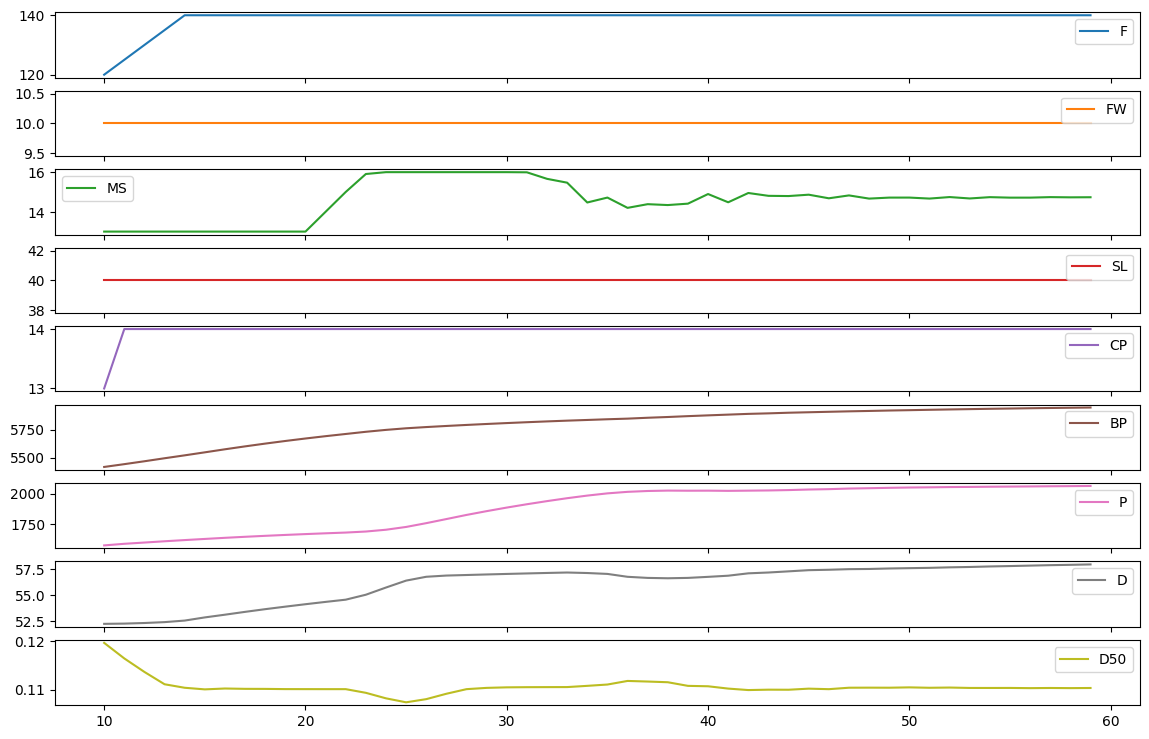

<Figure size 640x480 with 0 Axes>

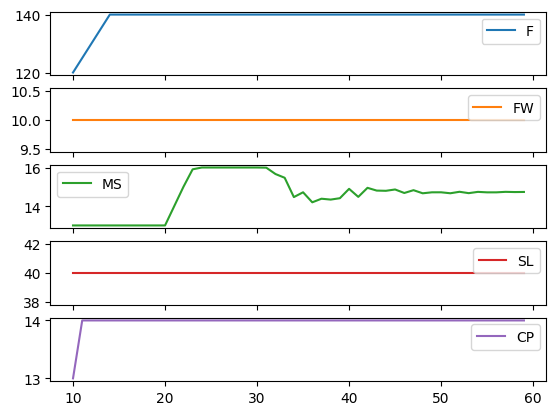

In [101]:
#plot MV moves
d=pd.DataFrame(dfr.T)
d.columns= ['F','FW','MS','SL','CP']

#plot CV simulation 
d1=pd.DataFrame(dfx.T)
d1.columns= ['BP','P','D','D50']

dbig=pd.concat([d,d1],axis=1);
plt.figure();
dbig[10:-1].plot(kind='line',subplots=True, figsize=(14,9));
plt.show();

# plt.figure(1);
# dw=pd.DataFrame(dfw.T)
# dw.columns= ['F','FW','MS','SL','CP']
# dw[10:-1].plot(subplots=True)
# plt.show()

In [72]:
#to excel!
dfsp=pd.DataFrame(np.array([BPsp.T ,Psp.T  ,Dsp.T ,D50sp.T]).T)
#dfsp=dfsp.drop(4)
#dfsp=dfsp.reset_index()
dftot=pd.concat((dbig,dfsp),axis=1)
dftot.to_excel('plot_data3.xlsx',header=True,index=True)

60 min example
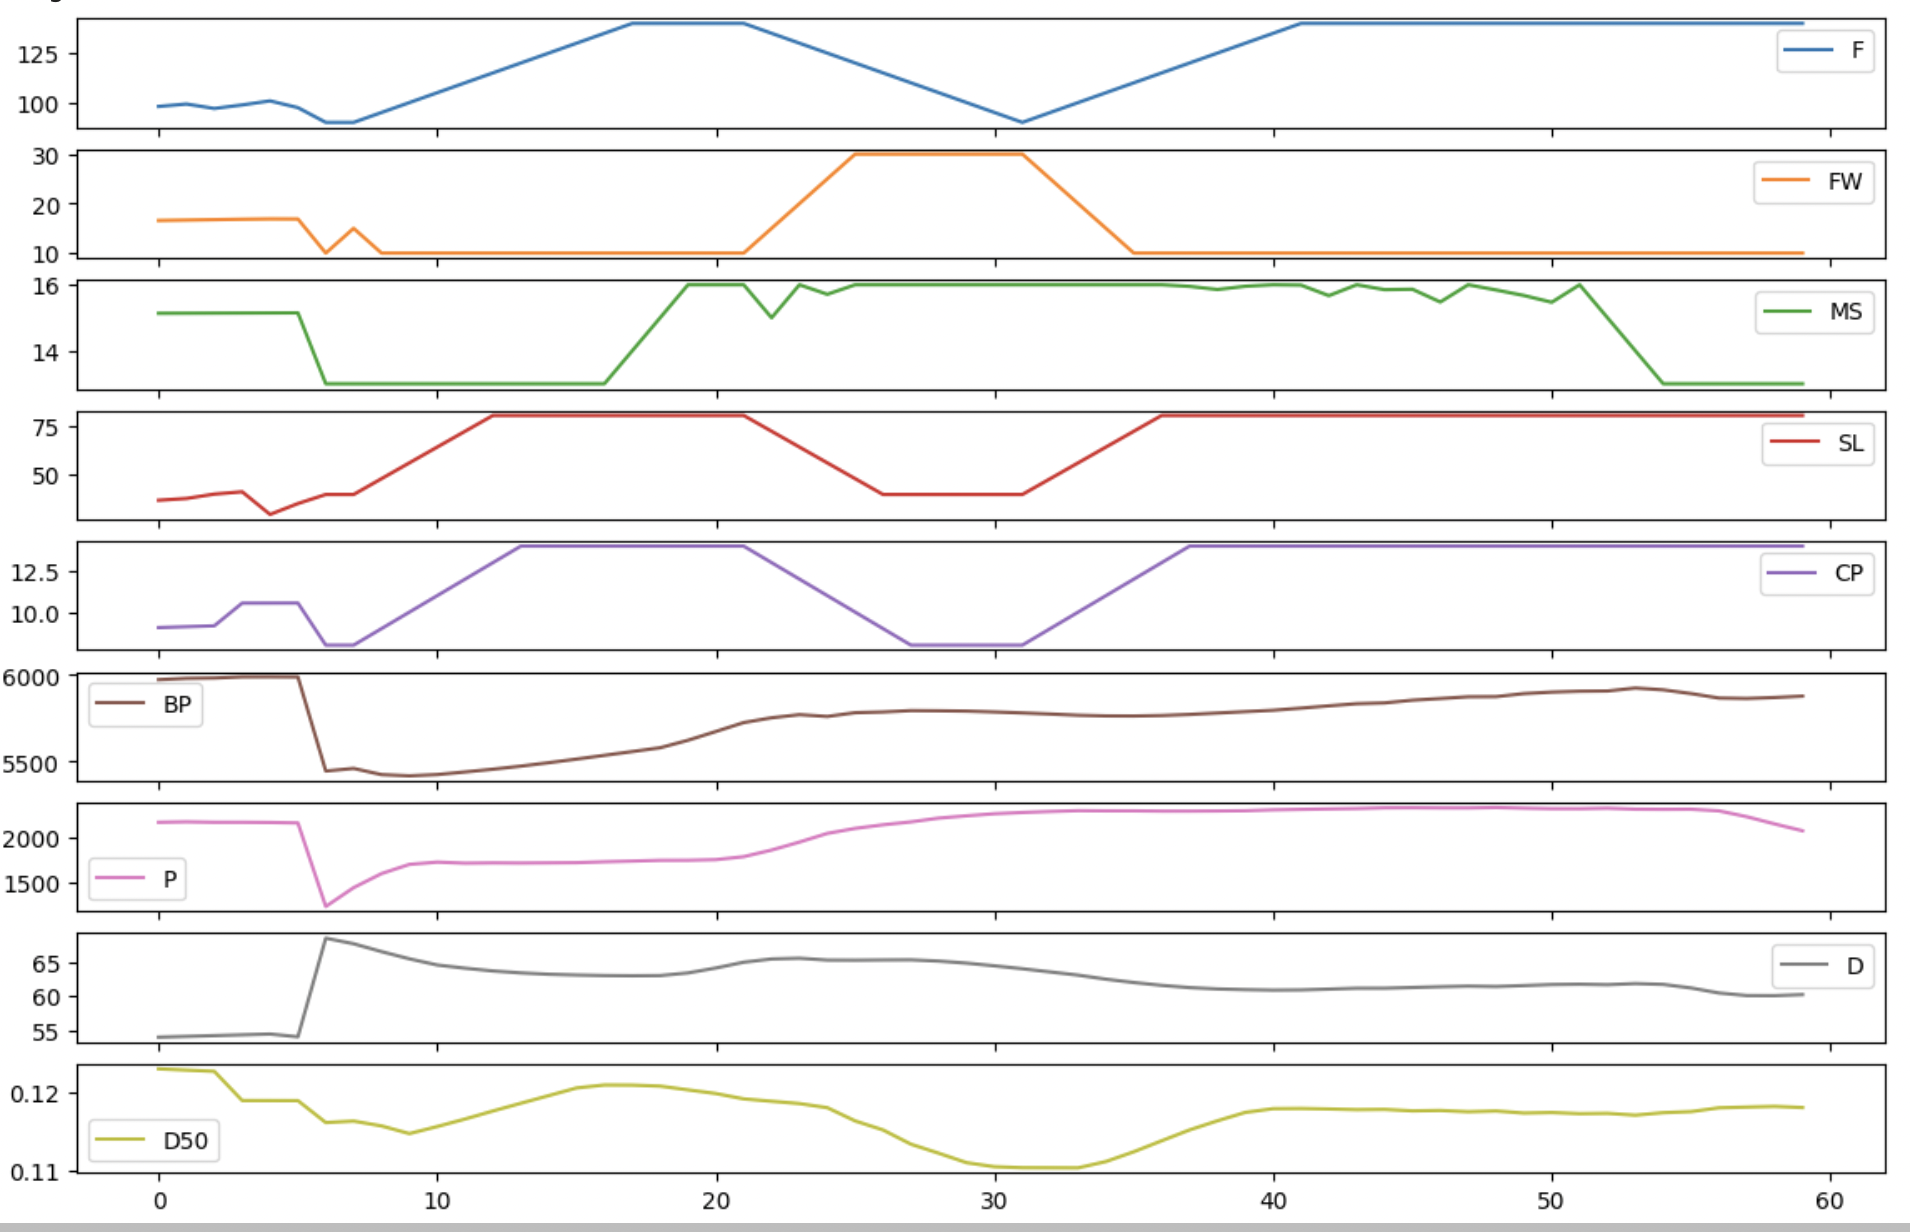